In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp

import paragami 

from structure_vb_lib import structure_model_lib, data_utils, plotting_utils, posterior_quantities_lib

from bnpmodeling_runjingdev import result_loading_utils, cluster_quantities_lib

import time

import matplotlib.pyplot as plt
%matplotlib inline  

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Files

In [2]:
# data_file = '../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename = 'huang2011_fit'
# out_folder = '../fits/hgdp_fits/'

data_file='../data/huang2011_sub_nobs25_nloci75.npz'
out_filename='huang2011_fit_sub'
out_folder='../fits/tmp/'

# Load data

In [3]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [5]:
print(n_obs)
print(n_loci)

25
75


# Load fits

### load first fit to get metadata

In [6]:
alpha0 = 6.0
init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'

In [7]:
vb_opt_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, meta_data = \
            structure_model_lib.load_structure_fit(init_fit_file)

In [8]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)
assert prior_params_dict['dp_prior_alpha'] == alpha0

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


Text(0.5, 0, 'Individuals')

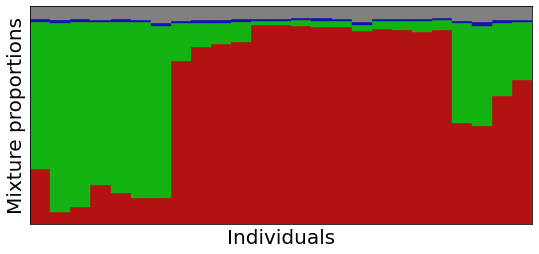

In [9]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(9, 4))
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 3)

axarr.set_ylabel('Mixture proportions', fontsize = 20)
axarr.set_xlabel('Individuals', fontsize = 20)

### load all refits

In [10]:
match_crit = out_filename + '_alpha\d.*.npz'

In [11]:
vb_refit_list, refit_meta_data = result_loading_utils.load_refit_files(out_folder, match_crit)

unable to load file:  huang2011_fit_sub_alpha6.0_lrderivatives.npz


In [12]:
alpha_vec = result_loading_utils._load_meta_data_from_list(refit_meta_data, 'dp_prior_alpha').squeeze()
refit_times = result_loading_utils._load_meta_data_from_list(refit_meta_data, 'optim_time')

In [13]:
# for convencience, sort the alphas 
_indx = onp.argsort(alpha_vec)
alpha_vec = alpha_vec[_indx]
vb_refit_list = vb_refit_list[_indx]
refit_times = refit_times[_indx]

In [14]:
alpha_vec

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ])

In [15]:
# no gaps 
np.all(np.diff(alpha_vec) == 0.5)

DeviceArray(True, dtype=bool)

# Define linear response 

In [16]:
lr_file = out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

In [18]:
print('lr file: ', out_folder + lr_file)

lr_data = np.load(out_folder + lr_file)
assert lr_data['dp_prior_alpha'] == alpha0
assert np.all(lr_data['vb_opt'] == vb_opt)

print('derivative time: {:.3f}secs'.format(lr_data['lr_time_alpha']))

lr file:  ../fits/tmp/huang2011_fit_sub_alpha6.0_lrderivatives.npz
derivative time: 0.694secs


In [19]:
alpha0_free = prior_params_paragami['dp_prior_alpha'].\
                flatten(prior_params_dict['dp_prior_alpha'], free = True)

def predict_opt_par_from_hyper_par(alpha_pert): 
    alpha_pert_free = prior_params_paragami['dp_prior_alpha'].\
                flatten(alpha_pert, free = True)
    
    delta = alpha_pert_free - alpha0_free
        
    return vb_opt + lr_data['dinput_dalpha'] * delta

In [20]:
t0 = time.time()
lr_list = []
for i in range(len(alpha_vec)): 

    lr_list.append(predict_opt_par_from_hyper_par(alpha_vec[i]))

# computing the vb parameters are fast!
print('lr time: {:03f}secs'.format(time.time() - t0))

lr time: 0.100037secs


# compare against refit results

### Results on expected number of clusters

In [47]:
seed = 2342
key = jax.random.PRNGKey(seed)

@jax.jit
def get_e_num_clusters(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs, vb_params_dict, gh_loc, gh_weights, 
                                                   n_samples = 1000,
                                                   threshold = g_obs.shape[0] * g_obs.shape[1] * 0.01,
                                                   prng_key = key)

@jax.jit
def get_e_num_pred_clusters(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       prng_key = key, 
                                                       n_samples = 1000, 
                                                       threshold = 0)

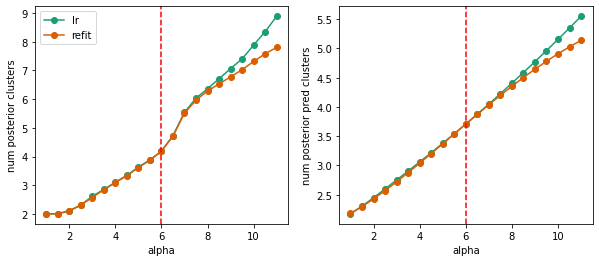

In [48]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

result_loading_utils.plot_post_stat_per_epsilon(get_e_num_clusters, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    alpha_vec,
                                                    axarr[0])

result_loading_utils.plot_post_stat_per_epsilon(get_e_num_pred_clusters, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    alpha_vec,
                                                    axarr[1])

axarr[0].set_xlabel('alpha')
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend(('lr', 'refit'))

axarr[1].set_xlabel('alpha')
axarr[1].set_ylabel('num posterior pred clusters')

for i in range(2): 
    axarr[i].axvline(alpha0, color = 'red', linestyle = 'dashed')

### Check out results on mixture weights

In [23]:
@jax.jit
def get_mixture_weights(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, gh_loc, gh_weights)

In [24]:
def plot_e_num_obs_trace(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, vb_refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(alpha_vec, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(alpha_vec, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k))
        ax[x0, x1].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('dp_prior_alpha')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# obs)')
    
    fig.tight_layout()


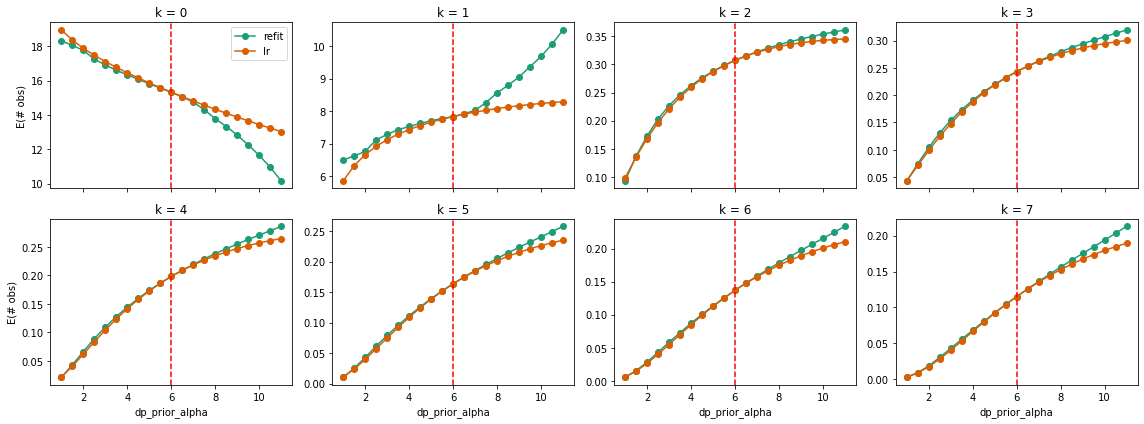

In [25]:
plot_e_num_obs_trace()

### Check out results on co-clustering

In [26]:
def get_e_ind_admix(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 
        
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    return e_ind_admix

In [27]:
e_ind_admix_init = get_e_ind_admix(vb_opt)
indx = data_utils.cluster_admix_get_indx(e_ind_admix_init)

In [28]:
@jax.jit
def get_coclustering(vb_free_params): 
    
    e_ind_admix = get_e_ind_admix(vb_free_params)[indx]
    
    return np.dot(e_ind_admix, e_ind_admix.transpose())


In [29]:
def get_coclust_mean_abs_diff(vb_params_free): 
    init_coclust = get_coclustering(vb_opt)
    pert_coclust = get_coclustering(vb_params_free) 
    
    return np.abs(pert_coclust - init_coclust).mean()


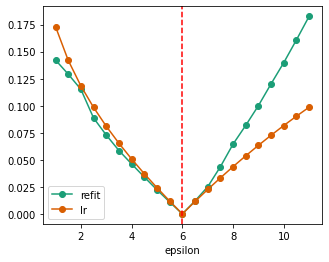

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

result_loading_utils.plot_post_stat_per_epsilon(get_coclust_mean_abs_diff, 
                                               vb_refit_list,
                                               lr_list,
                                               alpha_vec, 
                                               ax)
ax.axvline(alpha0, 
           color = 'red', 
           linestyle = '--')

ax.legend()


In [31]:
# pick a particular alpha
alpha_pert = 11
alpha_indx = np.argwhere(alpha_vec == alpha_pert).squeeze()

In [32]:
coclust_init = get_coclustering(vb_opt)
coclust_lr = get_coclustering(lr_list[alpha_indx])
coclust_refit = get_coclustering(vb_refit_list[alpha_indx])

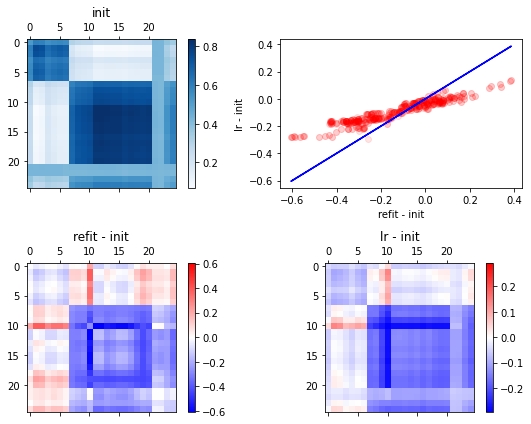

In [33]:
fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

################
# initial co-clustering matrix
################
im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

################
# differences
################
result_loading_utils.print_diff_plot(coclust_refit.flatten(),
                                     coclust_lr.flatten(), 
                                    coclust_init.flatten(), 
                                    axarr[0, 1], 
                                    alpha = 0.1)

result_loading_utils.plot_colormaps(coclust_refit,
                                   coclust_lr,
                                   coclust_init,
                                   fig,
                                   axarr[1], 
                                   plot_initial = False)
    
fig.tight_layout()


# Print refit times

In [34]:
# recal LR time
print('derivative time: {:.3f}secs'.format(lr_data['lr_time_alpha']))

derivative time: 0.694secs


In [35]:
initial_refit_time = refit_times[alpha_vec == 6.0]
initial_refit_time

array([9.92481875])

In [36]:
refit_times

array([ 6.1343565 ,  5.95048928,  6.22080231,  4.94788551,  4.52876163,
        3.96122479,  4.18242693,  3.94451475,  3.34131622,  3.34445405,
        9.92481875,  3.3421948 ,  4.13791347,  6.63451719,  6.91718531,
        7.78728175,  8.10585046,  9.37843847,  9.40028381, 10.16277766,
       10.45706534])